# In or out of interest area
in the first section of the notebook we are going to see how we can detect if a person is in or out of interest area

In [2]:
# load libraries
from skimage.transform import resize
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In order to define if a given person is in or out of an area of interest - we first need to define the area of interest. We are using the Reolink app to define an alerting area and fetch this data from the camera via a python script which gets logged in our [Reolink/log/Reolink_motion_alerts_Eingang.log](Reolink/log/Reolink_motion_alerts_Eingang.log) files. Here we need now to extract the information about the area of interest from the log file to define if a tracked person is in or out of the defined area.  

But for now lets have a look at the important section of the log file which we need to extract

In [2]:
# show a part of the log file to illustrate the structure of the file
!head -7 Reolink/log/Reolink_motion_alerts_Eingang_part1.log

2022-03-19 21:51:26 [    INFO] ===================== Start Monitoring Motion of Reolink Camera ====================
2022-03-19 21:51:26 [    INFO] camera source:           Eingang, frameRate:               10
2022-03-19 21:51:26 [    INFO] resolution:              2304*1296, bitRate:                 6144
2022-03-19 21:51:26 [    INFO] ------------------------------------------------------------------------------------
2022-03-19 21:51:26 [    INFO] start time:              2022-03-19 21:51:26
2022-03-19 21:51:26 [    INFO] ====================================================================================
2022-03-19 21:51:26 [    INFO] alarm area (72, 40):00000000000000000000000000011111111111111111111111111111000000000000011100000000000000000000000000011111111111111111111111111111000000000000011100000000000000000000000000011111111111111111111111111111100000000000011100000000000000000000000000011111111111111111111111111111111100000000011100000000000000000000000000011111111111111111111

as you can see when ever the script is initiated we are logging the main settings of the camera such as:

+ camera source
+ frameRate
+ resolution
+ bitRate
+ start time
+ alarm area in a shriked format (rows, columns & mask matrix) all of these information are relevant to adjust our cusomized YOLO/DeepSORT module.

Lets extract these information to get a sense of where the interest area is (alerting area)

In [4]:
# helper function
with open("Reolink/log/Reolink_motion_alerts_Eingang_part1.log", "r") as f: 
    lines = f.readlines()
for l in lines:
    if re.match(".*resolution.*",l):
        pat = re.match(".*resolution:\s+(\d+)\*(\d+).*",l)
        w = int(pat.group(1))
        h = int(pat.group(2))
        print(w,h)
    elif re.match(".*alarm area.*",l):
        pat = re.match(".*alarm.area.\((\d+),.(\d+)\):(\d+)",l)
        rows = int(pat.group(1))
        cols = int(pat.group(2))
        mask = pat.group(3)

        mask = resize(np.array([int(s) for s in mask]).reshape(cols,rows), (h,w))
        
        print(mask.shape)
        break

2304 1296
(1296, 2304)


As we have extracted all the necessary information. Lets plot the mask which indicates the alerting area in yellow

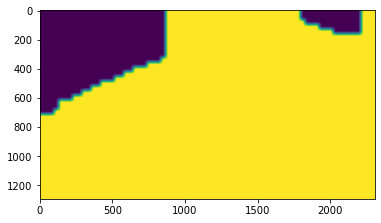

In [5]:
# lets standardize it
mask /= mask.max()
plt.imshow(mask)

Next we have will have a look at a frame of the video stream to get a scene if these areas make sense

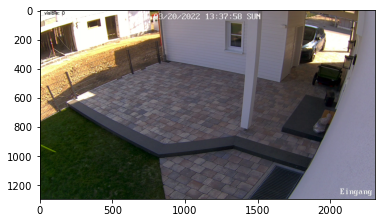

In [8]:
pic = plt.imread("pics/test.png")
plt.imshow(pic)

Now lets overlay it to see if these areas make sense

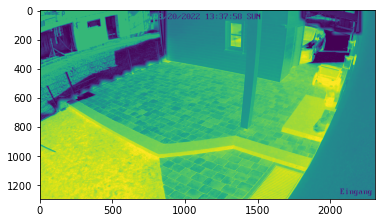

In [58]:
overlay = abs(mask-pic[:,:,0])
plt.imshow(overlay) 

so the interest area makes sense it really is along the property boarder at the fence and towards the road. Now we can simulate a detected person and see one it is defined as in or out of interest area

In [130]:
# helper functions 

# simulate a detected person and draw that person on the frame
def person_detect(in_or_out, xy=(350,400),w=150,h=240):
    # needs to be given if the detected person is in or out of area
    if in_or_out==True:
        col = "green"
        alpha = 0.5
    elif in_or_out == False:
        col = "red"
        alpha = 0.5
    else:
        col = "black"
        in_or_out = False
        alpha = 1
    
        
    rect=mpatches.Rectangle(xy,w,h, 
                        fill = in_or_out,
                        color = col,
                        alpha=alpha,
                        linewidth = 2)
    return rect

# evaluate if the person is in or out of interest area
def in_or_out(mask, x1,y1,w,h, thr=80):
    x2, y2 = (int(x1+w), int(y1+h)) 
    rec = np.zeros(mask.shape)
    rec[y1:y2,x1:x2] = 100
    test = (mask-rec)
    in_out = test[int(y2*0.9):y2,x1:x2].mean() > thr
    return in_out

this person is for sure in the interest area. How about the next one one?


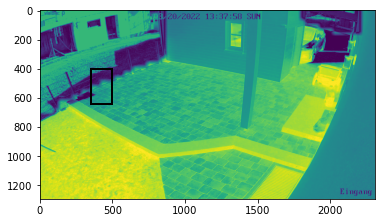

In [136]:
person = person_detect(in_or_out="demo")
print("this person is for sure in the interest area. How about the next one?")
plt.imshow(overlay) 
plt.gca().add_patch(person)

this person is also in the interest area. Lets simulate when its in or out of interest area?


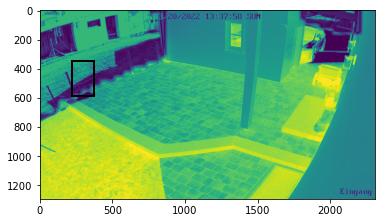

In [149]:
print("this person is also in the interest area - but its harder to tell. Lets simulate when its in or out of interest area?")
person = person_detect(xy=(220,350), in_or_out="demo")
plt.imshow(overlay) 
plt.gca().add_patch(person)

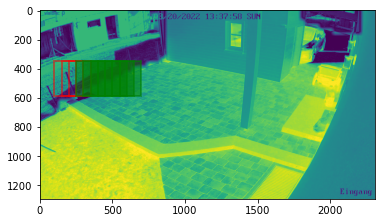

In [150]:
print("the green marked ectangles are in the interest area while the red rectangles are out of the interest area")
for x in range(100,600,50):
    xy=(x,350)
    w=150
    h=240
    in_out = in_or_out(mask,xy[0],xy[1],w,h)
    person = person_detect(xy=(x,350), in_or_out=in_out)
    plt.imshow(overlay) 
    plt.gca().add_patch(person)


We have simulated it in all kind of directions - and our estimation seems to work pretty good (also evaluated see [03_model_evaluation.ipynb](03_model_evaluation.ipynb) ) by just looking at the lowest 10 of the bounding box - this should simulate the feed of the person and look if its in or out. here we compare the area which is in or out of the mask 

# next we can have a look at another processing step we are doing before parsing a detected face towards FaceNet.

why are we recentering the face and expand the sites of the face before we recognize the person?

In [6]:
# import libraries
from PIL import Image
from mtcnn.mtcnn import MTCNN
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Lets consider a image that was taken by our system. Its my daughter running around. If you think the resolution of this image is good enough - lets wait until we see the resolution of the actual face that is used to make any recognition

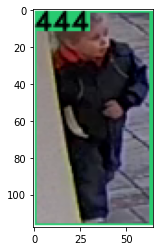

In [7]:
image_path = "pics/2022March11_16_49_06_Terrasse535906_crop_track_444.png"
pic = plt.imread(image_path)
plt.imshow(pic)

But before we show you this we need to write some helper functions

In [9]:
def import_png(image_path):
    if image_path.split(".")[-1].lower() == "png":
    # png have 4 channels R,G,B and alpha for transparency --> here we get rid of the aloha/transperency channel
        try:
            image = Image.open(image_path).convert('RGBA')
            background = Image.new('RGBA', image.size, (255,255,255))
            alpha_composite = Image.alpha_composite(background, image)
            alpha_composite_3 = alpha_composite.convert('RGB')
            pic = np.asarray(alpha_composite_3)

        except Exception as e:
            print("[WARNING] there was an error in this image {} - maybe it is truncated?".format(image_path))
            print(e)
            return None
    return pic
        
def super_resolution(img, model="lapsrn", zoom=8):
        sr = cv2.dnn_superres.DnnSuperResImpl_create()
        path = "smart_surveillance/FaceRecognition/superresolution_models/"
        path = [path + i for i in os.listdir(path) if (i.split("_")[0].lower() == model) & (int(i.split("_")[1][1]) == zoom)][0]
        sr.readModel(path) 
        sr.setModel(model, zoom) # set the model by passing the value and the upsampling ratio
        result = sr.upsample(img) # upscale the input image
        return result

def recenter_crop_face(pic, faces, with_recenter=False):
    x1, y1, width, height = faces['box']
    x2, y2 = x1 + width, y1 + height
    dim = pic.shape
    if with_recenter:

        # recenter the detected rectangle around the face
        circles = faces['keypoints'].values() # rember keypoints contain dic of landmarks in format of tuple(x,y)
        center = (sum(k[0] for k in circles)/len(circles), sum(k[1] for k in circles)/len(circles))


        ### adjust the ratio of the rectangle towards the longer side of height and width
        ### remember input for FaceNet is 160x160 as we don t want to deform the face by resizing it
        ### we recenter the rectangle and keep same side size                
        # determine the longer side of width and height
        MAX = int(np.max([width, height]))
        x1, x2, y1, y2 = (int(center[0]-MAX/2), int(center[0]+MAX/2), int(center[1]-MAX/2), int(center[1]+MAX/2))

        # check for the cases that we go out of the image with the new rectangle

        # in case we go out of the left side of the image
        if x1 < 0: 
            # add the part which was over the left side and add it to the right side of the rectangle
            x2 += x1*-1
            # set the left point to the border of the left side of the image
            x1 = 0
        # in case we go out of the right side of the image
        if x2 > dim[1]:
            # add the part which was over the right side and add it to the left side of the rectangle
            x1 -= x2-dim[1]
            # set the right point to the border of the right side of the image
            x2 = dim[1]
        # in case we go out of the top side of the image
        if y1 < 0:    
            # add the part which was over the top part and add it to the bottom part of the rectangle
            y2 += y1*-1
            # set the top point to the boarder of the top part of the image
            y1 = 0
        # in case we go out of the bottom part of the image
        if y2 > dim[0]:
            # add the part which was over the bottom part and add it to the top part of the rectangle
            y1 -= y2-dim[0]
            # set the bottom point to the boarder of the bottom part of the image
            y2 = dim[0]
        
    return pic[y1:y2, x1:x2]




before we run this code we need to tell tensorflow not to use the whole GPU and only take as much as it needs. Otherwise its impossible to run other things like YOLO and so in paralell (for this notebook not so important but for the system it is).

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-04-24 20:47:07.213769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 20:47:07.238937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 20:47:07.239105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 20:47:07.239924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Next we need to detect the face of my daughter

2022-04-24 20:47:12.316104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


2022-04-24 20:47:13.438050: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[{'box': [24, 4, 17, 23],
  'confidence': 0.9591215252876282,
  'keypoints': {'left_eye': (33, 13),
   'right_eye': (39, 13),
   'nose': (40, 18),
   'mouth_left': (34, 22),
   'mouth_right': (39, 22)}}]

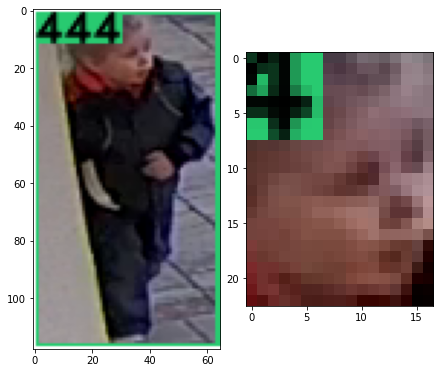

In [11]:
pic = import_png(image_path)
detector = MTCNN()
face_orig = detector.detect_faces(pic)

fig,ax = plt.subplots(1,2, figsize=(6,6), constrained_layout=True)
ax[0].imshow(pic)
ax[1].imshow(recenter_crop_face(pic, face_orig[0]))
face_orig

so as written in the report MTCNN predicts the bounding box of the face together with 5 landmarks in the face (right and left eye, the nose, left and right mouth). we also have a confidence how certain MTCNN is to detect a face. We are using all of thse information in our system. The landmarks for recentering the face, and the confidence to priorities if there are multiple faces detected in a image like the one of my daughter here.  

I guess now it becomes clear why we need to upsample the face image. Its really difficult to identify anyone. So for this you could do a simple interpolation using cv2.resize for example - how for certain situation its not ideal as its just guessing the missing pixels by interppolating. if one increase the resolution to high its just as pixeled as before just bigger. Lets have a look and compare it with a neural netwrok approach using called super_resolution (also described in the report)

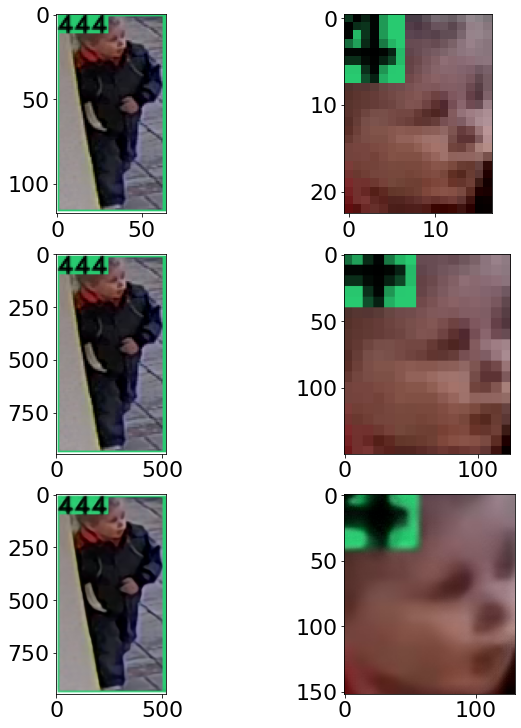

In [12]:
pic_super = super_resolution(pic)
dim = pic_super.shape
pic_res = cv2.resize(pic, (dim[1], dim[0]), interpolation=cv2.INTER_NEAREST)

face_super = detector.detect_faces(pic_super)
face_res = detector.detect_faces(pic_res)

fig,ax = plt.subplots(3,2, figsize=(8,10), constrained_layout=True)
for j in [0,1]:
    for i in [0,1,2]:
        ax[i,j].set_anchor("W")
        ax[i,j].tick_params(axis='both', which='major', labelsize=22)
        
ax[0,0].imshow(pic)
ax[1,0].imshow(pic_res)
ax[2,0].imshow(pic_super)

ax[0,1].imshow(recenter_crop_face(pic, face_orig[0]))
ax[1,1].imshow(recenter_crop_face(pic_res, face_res[0]))
ax[2,1].imshow(recenter_crop_face(pic_super, face_super[0]))

So we can see that the resolution is now the same for both the resize function and the super resolution method. However, its still less pleasend for the eye in the interpolation method compared to the super_resolution method. It actually looks like the same as the original one just bigger. SO now we see that there is an improvment with the super_resolution method but we have another issue. FaceNet needs an input of 160x160 pixels and the height and width is often unequal because of the form of our heads :-D. So either we just resize it with a proper function or we need to recenter it and recrop it. Lets see the difference side by side

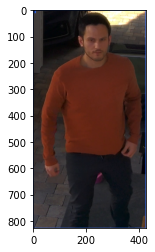

In [13]:
path1 = "pics/2022March27_16_17_29_Eingang1817_crop_track_1.png"
pic1 = import_png(path1)
plt.imshow(pic1)

Now lets consider this image. Its me walking towards the door. Can you see the difference yourself between the recentered and resized version?

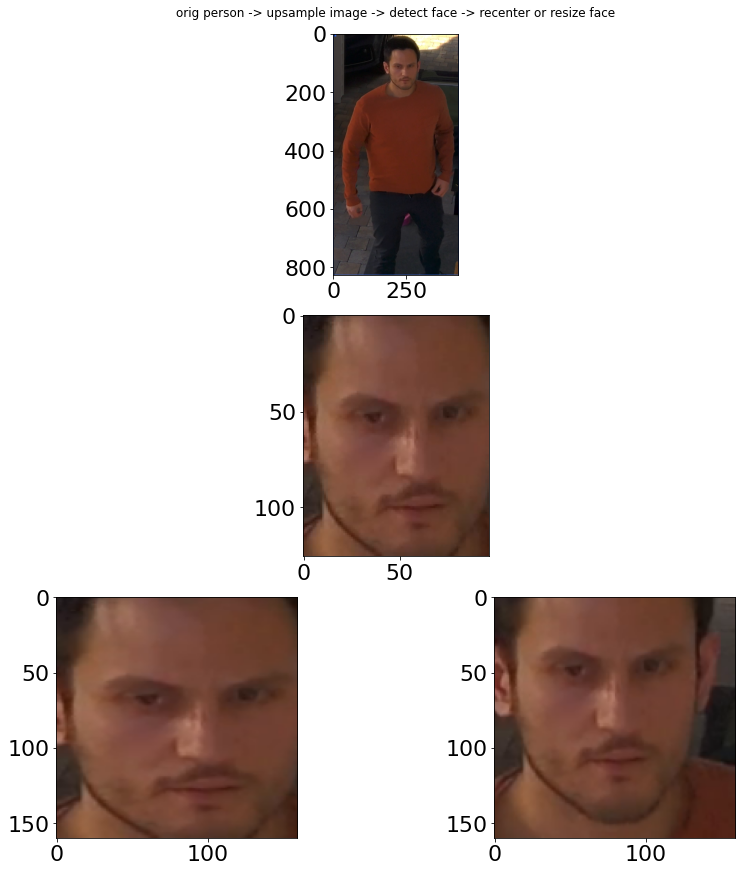

In [14]:
detector = MTCNN()

face_orig = detector.detect_faces(pic1)

no_rec1 = recenter_crop_face(pic1, face_orig[0],with_recenter=False)
rec1 = recenter_crop_face(pic1, face_orig[0],with_recenter=True)

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
#         ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
#         ax.set_anchor("W")
        ax.tick_params(axis='both', which='major', labelsize=22)
#         ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(12,12))
gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1,:])
# ax3 = fig.add_subplot(gs[2:, -1])
ax4 = fig.add_subplot(gs[2, :2])
ax5 = fig.add_subplot(gs[2, 2:])

fig.suptitle("orig person -> upsample image -> detect face -> recenter or resize face")
format_axes(fig)
ax1.imshow(pic1)
ax2.imshow(no_rec1)
ax4.imshow(cv2.resize(no_rec1, (160, 160)))
ax5.imshow(cv2.resize(rec1, (160, 160)))
plt.show()

exactly while we distort the face by just resizing it we will have a non distored face when we just recenter and recrop the image. In this way we can feed it to our feature extractor FaceNet